# Implement a Neural Network from scratch using NumPy

In [1]:
# from google.colab import drive
# drive.mount('/content/drive/')

# %cd /content/drive/My Drive/Datasets/Traffic Sign Images

Mounted at /content/drive/
/content/drive/My Drive/Datasets/Traffic Sign Images


* Importing necessary libraries

In [ ]:
# ! pip install seaborn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')
import pickle

## Loading and Preparing Images for the Neural Network
   * Load the train and test images. Images are stored in the pickle file.
   * Images and their corresponding labels are stored as lists, so convert them to numpy arrays. 
   * Shuffle the images now.
   * Then split the training dataset into a training and validation datasets.
   * Flatten all the images
   * Normalize the images to a range of [0,1].
   * Lastly, apply one hot encoding on the labels.

In [8]:
## loading data--use pickle library

with open('../data/train.pkl', 'rb') as train_data:
    train = pickle.load(train_data)

with open('../data/test.pkl', 'rb') as test_data:
    test = pickle.load(test_data)


In [10]:
## convert the datatype to numpy array
X_train_orig, y_train_orig = train[0], train[1]
X_train_orig = np.array(X_train_orig)
y_train_orig = np.array(y_train_orig)

X_test_orig, y_test_orig = test[0], test[1]
X_test_orig = np.array(X_test_orig)
y_test_orig = np.array(y_test_orig)

In [11]:
## shuffle the dataset, since the data is stored in ascending order of the labels.
def shuffle_dataset(X, y):
    assert len(X) == len(y)
    p = np.random.permutation(len(X))
    return X[p], y[p]

    
X_train_orig, y_train_orig = shuffle_dataset(X_train_orig, y_train_orig)
X_test_orig, y_test_orig = shuffle_dataset(X_test_orig, y_test_orig)

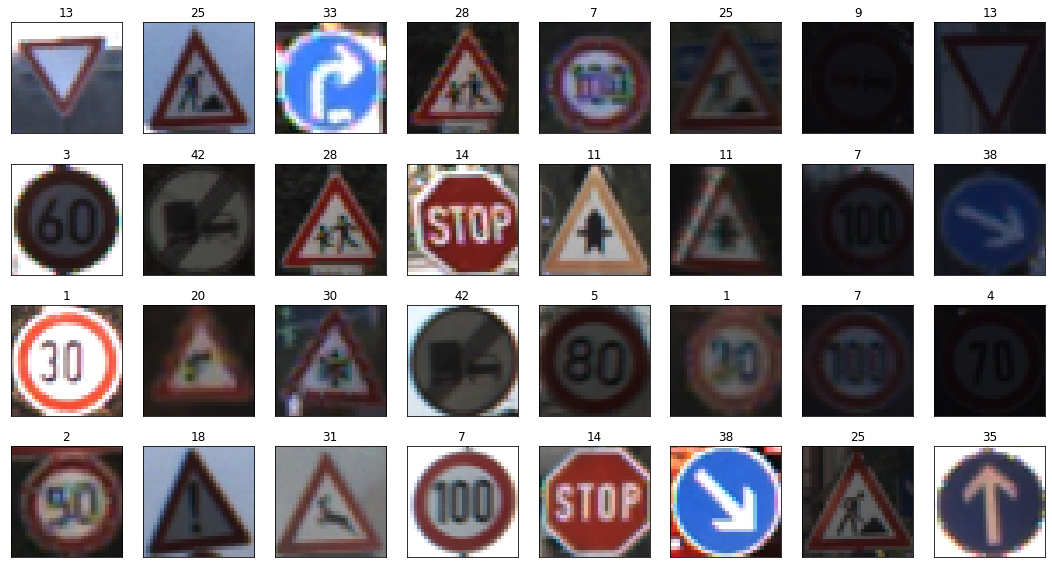

In [12]:
## visualizing the images randomly.

plt.figure(figsize=(15,8))
for i in range(32):
    plt.subplot(4,8,i+1)
    ind_ = np.random.randint(0,X_train_orig.shape[0])
    plt.imshow(X_train_orig[ind_])
    plt.title(y_train_orig[ind_])
    plt.yticks([])
    plt.xticks([])
    plt.tight_layout()

In [13]:
## split the training dataset to create a training and a validation dataset.
X_train_orig,X_valid_orig,y_train_orig,y_valid_orig = train_test_split(X_train_orig, y_train_orig, 
                                                                       test_size=0.2, random_state=0)

In [14]:
# reshaping the X values from (m , row, col, 3) to (row*col*3, m) (Flattening)
X_train_f = X_train_orig.reshape(X_train_orig.shape[0], -1).T
X_valid_f = X_valid_orig.reshape(X_valid_orig.shape[0], -1).T
X_test_f = X_test_orig.reshape(X_test_orig.shape[0], -1).T

print('Shape after flattening: ',X_train_f.shape, X_test_f.shape, y_test_orig.shape)

Shape after flattening:  (3072, 21312) (3072, 12630) (12630,)


In [15]:
# normalizing all the X values by dividing them by 255

X_train = X_train_f/255
X_valid = X_valid_f/255
X_test = X_test_f/255

In [1]:
## Lastly, apply one hot encoding on the labels of the images. 

In [16]:
def one_hot_encoding(y,classes):
    
    one_hot=np.zeros((len(classes), y.shape[1]))
    for i in range(y.shape[1]):
        var = y[0][i]
        one_hot[:,i][var] = 1
    return one_hot

In [17]:
classes = np.unique(y_train_orig) # there are 42 classes in this dataset

y_train = y_train_orig.reshape(1,-1)
y_valid = y_valid_orig.reshape(1,-1)
y_test = y_test_orig.reshape(1,-1)



In [18]:
y_train = one_hot_encoding(y_train, classes)
y_valid = one_hot_encoding(y_valid, classes)
y_test = one_hot_encoding(y_test, classes)
print('Shape after one hot encoding: ',y_train.shape, y_test.shape)

Shape after one hot encoding:  (43, 21312) (43, 12630)


## Creating a Neural Network


#### Initialize Parameters

- Use random initialization for the weight matrices. Use `np.random.randn(shape)* 2/sqrt(size[l-1])` with the correct shape.
- Use zero initialization for the biases. Use `np.zeros(shape)`.

In [19]:
def initialize_param(layer_dims):
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims)
    
    for l in range(1, L):
        parameters['W'+str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * (2/ np.sqrt(layer_dims[l-1]))
        parameters['b'+str(l)] = np.zeros((layer_dims[l], 1))
    return parameters

#### Now that we have initialized the parameters, we will do the forward propagation

The linear forward module (vectorized over all the examples) computes the following equations:

$$Z^{[l]} = W^{[l]}A^{[l-1]} +b^{[l]}\$$



* Forward propagation for a single layer

In [20]:
# if we have a multiclass problem, we'll use softmax func. Otherwise sigmoid

def S_forward_propagation(A_prev , W, b, activation):
    Z = np.dot(W, A_prev) + b     # W.shape == (n(l), n(l-1)), A_prev.shape == (n(l-1), m)
                                  # hence, Z.shape == (n(l), m)
    if activation == 'relu':     
        A = np.maximum(0,Z)       # if Z > 0 , A=Z -> else A=0
    elif activation == 'sigmoid':
        A = 1 / (1+np.exp(-Z))
    elif activation == 'softmax':
        t = np.exp(Z)
        sum_ = np.sum(t,axis=0).reshape(1,-1)
        A = t / sum_ 
        
    cache = (A_prev, Z, W, b)
    
    return A, cache



* Forward propagation for a [L] layers neural network.

In [21]:

def L_forward_propagation(A_prev , parameters):
    L = len(parameters) // 2
    caches = [] # it will carry (A_prev, Z, W,b)
    for l in range(1, L): # ..1st hidden layer to 2nd last hidden layer
        W, b = parameters['W'+str(l)], parameters['b'+str(l)]
        A, cache = S_forward_propagation(A_prev, W, b, activation='relu')
        caches.append(cache)
        A_prev = A  # ..current A will be A_prev in the next loop
    
    W, b = parameters['W'+str(L)], parameters['b'+str(L)] # ..for last hidden layer
    if W.shape[0] > 1: # if multiclass 
        AL, cache = S_forward_propagation(A_prev, W, b, activation='softmax')
    else:              # if binary
        AL, cache = S_forward_propagation(A_prev, W, b, activation='sigmoid')

    caches.append(cache)
    return AL, caches






#### Computing Regularized Cost

In [22]:
def compute_regularized_cost(AL, y , lambd, parameters):
    
    m = y.shape[1]
    cost = (1/m) * -(np.sum(y * np.log(AL))) 
    
    L = len(parameters) // 2  # ..number of Layers
    
    reg = 0
    for l in range(1, L+1):
        reg = reg + np.sum(np.square(parameters['W'+str(l)])) # computes regularization for every layer..
    
    reg_cost = cost + (lambd/(2*m)) * reg
    
    return np.squeeze(reg_cost)

#### Back Propagation

Back propagation is used to calculate the gradient of the loss function with respect to the parameters. 

Derivative of cost function with respect to A2
   * dA2 = - (np.divide(y, A2) - np.divide(1 - y, 1 - A2)) 

* Computing gradients for all the parameters


In [23]:
def compute_grads(AL, y , caches, lambd):
    dZL = AL - y
    L = len(caches)
    grads = {}
    m = y.shape[1]
    
    A_prev = caches[L-1][0]          # if 3 Layered network, then caches[2] will contain (A2, Z3,W3,b3)
    W = caches[L-1][2]               
    grads['dW'+str(L)] = 1/m * np.dot(dZL, A_prev.T) + ((lambd/m) * W)
    # dZL.shape==(n(L), m) , A_prev.T.shape == (m, n(L-1))
    # hence, dW.shape == (n(L), n(L-1))
    grads['db'+str(L)] = 1/m * np.sum(dZL, axis=1, keepdims=True)
    
    dZ = dZL
    for l in range(L-1, 0,-1):
        A, A_prev = caches[l][0] , caches[l-1][0]
        Wahead , W = caches[l][2] , caches[l-1][2]        
        
        dA = np.dot(Wahead.T, dZ) # dZ ahead
        # Wahead.shape == (n(l), n(l+1)), dZahead.shape == (n(l+1),m)
        dZ = np.multiply(dA, np.int64(A > 0))
        grads['dW'+str(l)] = 1/m * np.dot(dZ, A_prev.T) + ((lambd/m) * W)
        grads['db'+str(l)] = 1/m * np.sum(dZ, axis=1, keepdims=True)
        
    return grads   


#### Update Parameters

Now we will update the parameters of the model, using gradient descent: 

$$ W^{[l]} = W^{[l]} - \alpha \text{ } dW^{[l]} $$
$$ b^{[l]} = b^{[l]} - \alpha \text{ } db^{[l]} $$

In [24]:
def update_parameters(parameters, grads, alpha):
    L = len(parameters) // 2
    
    updated_params = {}
    
    for l in range(1, L+1):
        updated_params['W'+str(l)] =parameters['W'+str(l)] - alpha * grads['dW'+str(l)] 
        updated_params['b'+str(l)] =parameters['b'+str(l)] - alpha * grads['db'+str(l)]         
        
    return updated_params

#### Helper functions for evaluating the model.

* The following function will be useful for evaluating the model's performance while tuning the hyper-parameters.

In [25]:
def predict(weights, X):
    AL,_ = L_forward_propagation(X, weights)
    return np.int64(AL >= 0.5)

def accuracy(y, ypred):
    return np.mean(np.argmax(y,axis=0) == np.argmax(ypred, axis=0))*100

#### Creating an Adam optimizer

* Making batches of shape (nx , n) from the entire dataset where n is the size of the batch.

In [26]:
def mini_batch(X,y, size,seed):
    
    import math
    np.random.seed(seed)
    m = X.shape[1]
    num = math.floor(m/size)  # no. of complete batches
    permutation = list(np.random.permutation(m)) # shuffling the dataset
    Xshuffled = X[:,permutation]
    yshuffled = y[:,permutation]    
    
    batches = []
    for i in range(num):
        minibatchX = Xshuffled[:, i*size : (i+1)*size]
        minibatchy = yshuffled[:, i*size : (i+1)*size]        
        minibatch = minibatchX, minibatchy
        batches.append(minibatch)
        
    rem = m%size  # for remaining values form a new, incomplete batch
    if rem != 0: 
        minibatchX = Xshuffled[:, -rem:]
        minibatchy = yshuffled[:, -rem:]   
        minibatch = minibatchX, minibatchy
        batches.append(minibatch)
    
    return batches

##### Initializing [v] and [s].
* Both v and s will have a shape similar to W(weights) and b(biases). However, v and s will be initialized to zero.

In [27]:
def initialize_adam(params):
    v = {}
    s = {}
    L = len(params)//2
    for l in range(1, L+1):
        v['dW'+str(l)] = np.zeros(params['W'+str(l)].shape)
        v['db'+str(l)] = np.zeros(params['b'+str(l)].shape)        

        s['dW'+str(l)] = np.zeros(params['W'+str(l)].shape)
        s['db'+str(l)] = np.zeros(params['b'+str(l)].shape)        

    return v,s

##### Updating Parameters with ADAM

* Updating parameters using [v] and [s]. 
* v_corr and s_corr is basically computed to account for bias correction.
* E == epsilon to make sure we are not dividing v_corr by 0 while updating parameter. (avoid zero error)
* t = iteration number



In [28]:
def update_params_with_adam(params, grads, v,s, t, beta1,beta2,E,learning_rate):
    
    L = len(params) // 2
    v_corr = {}
    s_corr = {}
 
    
    for l in range(1,L+1):
        v['dW'+str(l)] = v['dW'+str(l)] * beta1 + (1-beta1) * grads['dW'+str(l)]  ## momentum 
        v['db'+str(l)] = v['db'+str(l)] * beta1 + (1-beta1) * grads['db'+str(l)]  # v[dWl]*beta1 + (1-beta1) * grad[dWl] 
        
        v_corr['dW'+str(l)] = v['dW'+str(l)] / (1-beta1**t)                       # v[dWl] / (1-beta1**t) ## t = iteration no.
        v_corr['db'+str(l)] = v['db'+str(l)] / (1-beta1**t)

        s['dW'+str(l)] = s['dW'+str(l)] * beta2 + (1-beta2) * grads['dW'+str(l)]**2  ## rmsprop
        s['db'+str(l)] = s['db'+str(l)] * beta2 + (1-beta2) * grads['db'+str(l)]**2  #  s[dWl]*beta2 + (1-beta2) * grad[dWl]**2
        
        s_corr['dW'+str(l)] = s['dW'+str(l)] / (1-beta2**t)                          # s[dWl] / (1-beta1**t) ## t = iteration no.
        s_corr['db'+str(l)] = s['db'+str(l)] / (1-beta2**t)
        
        params['W'+str(l)] = params['W'+str(l)] - learning_rate * (v_corr['dW'+str(l)] / (np.sqrt(s_corr['dW'+str(l)]) +E) ) 
                            # W - alpha * v_corr[dWl] / sqrt(s_corr[dWl] + E)
        params['b'+str(l)] = params['b'+str(l)] - learning_rate * (v_corr['db'+str(l)] / (np.sqrt(s_corr['db'+str(l)]) +E) ) 
        
        
    return params, v, s

#### Neural Network
* Finally, combine all of the preceding functions to create a complex neural network model.

In [29]:
def model_adam(X, y, nodes, alpha, epoch, size=512, beta1=0.9, beta2=0.999, E = 1e-8, lambd=0, print_cost=True):
     
    '''    
     X: input image, of shape (3072, number of examples)
     y: orignal labels with shape (43, number of examples) 
     nodes: dimensions of the layers (3072, hidden_node, 43)
     epochs -- number of epochs of the optimization loop
     alpha: learning rate 
     print_cost: If set to True, this will print the cost every 100 iterations 
    '''
    
    seed = 10
    parameters = initialize_param(nodes)
    L = len(parameters)//2
    m = y.shape[1]
    t = 0

    cost = []
    for i in range(epoch+1):
        v,s = initialize_adam(parameters)
        seed += 1
        # randomly shuffling the X and Y before creating batches at every epoch
        minibatches = mini_batch(X,y,size,seed) 
        cost_total = 0
        
        for minibatch in minibatches:
            (minibatchX, minibatchy) = minibatch
            AL, caches = L_forward_propagation(minibatchX, parameters)
            cost_total += compute_regularized_cost(AL, minibatchy, lambd, parameters)
            grad = compute_grads(AL, minibatchy, caches,lambd)
            t+=1
            parameters,v,s = update_params_with_adam(parameters,grad,v,s,t,beta1,beta2,E,alpha)
        
        cost_avg = cost_total/m    # sum of cost for every batch / m (total number of examples)
        
        if print_cost==True and i % 100 == 0:
            cost.append(cost_avg)
            print ("Cost after epoch {}: {}" .format(i, cost_avg))
            
    return cost, parameters       

### Hyper Parameter Tuning

* Tuning the paramters on the training dataset and evaluate the performance on the validation dataset.

In [30]:
for i in [[70],[100],[120,70],[100,50]]:
    for j in [0.001,0.0001, 0.00005,0.00001 ]:
        nodes = [X_train.shape[0]] + i + [y_train.shape[0]]
        _, weightA = model_adam(X_train, y_train, nodes, j,300, lambd=0.2,print_cost=False)
        accuracy_valid = np.mean(np.argmax(predict(weightA, X_valid),axis=0) == y_valid_orig)
        print('Accuracy achieved when hidden_nodes=={} and alpha=={}  : {}%'.format(i,j,np.round(accuracy_valid*100,2)))

## couldn't run this completely since it was taking a long time to execute, 
# we'll tune the parameters after decomposing the X values using PCA.


Accuracy achieved when hidden_nodes==[70] and alpha==0.001  : 94.84%
Accuracy achieved when hidden_nodes==[70] and alpha==0.0001  : 95.27%


KeyboardInterrupt: ignored

#### Reducing the size of the images with PCA
* Since training the model on the entire set of images is computationally expensive, we will use PCA to reduce the image size.

In [31]:
from sklearn.decomposition import PCA

In [32]:
## We will retain 99 percent of the variation in the images.
pca = PCA(0.99)


In [33]:
X_train_p=pca.fit_transform(X_train.T).T
X_valid_p=pca.transform(X_valid.T).T
# X_test_p=pca.transform(X_train.T).T



In [34]:
X_train_p.shape, X_valid_p.shape

((391, 21312), (391, 5328))

##### Hyperparamter tuning using the compressed images

In [35]:
# 2 hidden layers
[X_train_p.shape[0]] + [70,50] + [y_train.shape[0]]

[391, 70, 50, 43]

Tuning Learning Rate and Regularization Factor (lambd).

In [36]:
reg_factor = []
alpha = []
score= []
nodes = [X_train_p.shape[0]] + [70,50] + [y_train.shape[0]]
for i in [0.18, 0.2, 0.22]: # regularization factor
    for j in [0.0012, 0.001, 0.008]: # learning rate
        _, weightA = model_adam(X_train_p, y_train, nodes, j,300, lambd=i,print_cost=False)
        accuracy_valid = np.mean(np.argmax(predict(weightA, X_valid_p),axis=0) == y_valid_orig)
        print('Accuracy achieved when reg. factor == {} and alpha=={}  : {}%'.format(i,j,np.round(accuracy_valid*100,2)))
        alpha.append(j)
        reg_factor.append(i)
        score.append(accuracy_valid)

Accuracy achieved when reg. factor == 0.18 and alpha==0.0012  : 97.73%
Accuracy achieved when reg. factor == 0.18 and alpha==0.001  : 97.56%
Accuracy achieved when reg. factor == 0.18 and alpha==0.008  : 94.67%
Accuracy achieved when reg. factor == 0.2 and alpha==0.0012  : 98.1%
Accuracy achieved when reg. factor == 0.2 and alpha==0.001  : 97.92%
Accuracy achieved when reg. factor == 0.2 and alpha==0.008  : 94.29%
Accuracy achieved when reg. factor == 0.22 and alpha==0.0012  : 97.39%
Accuracy achieved when reg. factor == 0.22 and alpha==0.001  : 97.73%
Accuracy achieved when reg. factor == 0.22 and alpha==0.008  : 95.18%


In [37]:
tune_1 = pd.DataFrame({'learning_rate':alpha, 'lambda':reg_factor, 'accuracy':score})
tune_1.sort_values('accuracy',ascending=False)

,learning_rate,lambda,accuracy
3,0.0012,0.20,0.981044
4,0.0010,0.20,0.979167
0,0.0012,0.18,0.977290
7,0.0010,0.22,0.977290
1,0.0010,0.18,0.975601
6,0.0012,0.22,0.973911
8,0.0080,0.22,0.951764
2,0.0080,0.18,0.946697
5,0.0080,0.20,0.942943


OBSERVATIONS:
   * It appears that the best value for alpha is 0.0012, and the best value for the regularization factor is 0.2.


Now it's time to tune the number of hidden layers.

In [39]:
score= []
hidden_layers = []
for j in [[70,50],[100,70,50], [100,70,50,45]]: # number of hidden layers
    nodes = [X_train_p.shape[0]] + j + [y_train.shape[0]]
    _, weightA = model_adam(X_train_p, y_train, nodes, 0.0012, 300, lambd=0.2, size=1024,print_cost=False)
    accuracy_valid = np.mean(np.argmax(predict(weightA, X_valid_p),axis=0) == y_valid_orig)
    print('Accuracy achieved when the number of hidden layers are {} : {}%'.format(len(j),np.round(accuracy_valid*100,2)))
    hidden_layers.append(len(j))
    score.append(accuracy_valid)

Accuracy achieved when number of hidden layers are 2 : 98.27%
Accuracy achieved when number of hidden layers are 3 : 97.94%
Accuracy achieved when number of hidden layers are 4 : 97.8%


In [40]:
tune_3 = pd.DataFrame({'hidden_layers': hidden_layers, 'accuracy':score})
tune_3.sort_values('accuracy',ascending=False)

,hidden_layers,accuracy
0,2,0.982733
1,3,0.979354
2,4,0.978041


OBSERVATIONS:
   * Neural Network with 2 hidden layers performed the best, neural networks with more than 2 hidden layers were overfitting.
   * In the first hidden layer, we will keep 70 neurons and in the second hidden layer, we will keep 50 neurons.

##### Final Parameters
   * NEURONS = [X_train.shape[0], 70,50, y_train.shape[0]]
   * LEARNING RATE [alpha] = 0.0012
   * REGULARIZATION FACTOR [lambd] = 0.2
   * BATCH SIZE = 1024
   * EPOCHS = 300

### Training and Evaluating the model after tuning the hyper parameters.

In [43]:
nodes = [X_train_p.shape[0]] + [70,50] + [y_train.shape[0]]
_, weightA = model_adam(X_train_p, y_train, nodes, 0.0012, 300, lambd=0.2, size=1024)


Cost after epoch 0: 0.004532014762106997
Cost after epoch 100: 8.524199950767123e-05
Cost after epoch 200: 7.887123561912752e-05
Cost after epoch 300: 7.897973314735407e-05


#### Evaluating the performance of the Neural Network..

* Evaluate the performance using different metrics such as accuracy, F1 score, etc.
* Randomly visualize the predictions on the validation images.
* Moreover, inspect when the model is predicting inaccurately.
* Finally, evaluate the model on the test dataset after making any necessary changes to the model.

In [44]:
accuracy_train = np.mean(np.argmax(predict(weightA, X_train_p),axis=0) == y_train_orig)
accuracy_valid = np.mean(np.argmax(predict(weightA, X_valid_p),axis=0) == y_valid_orig)
print('Accuracy of training data: {}%, Accuracy of validation data: {}%'.format(np.round(accuracy_train*100,2), np.round(accuracy_valid*100,2)))

Accuracy of training data: 99.85%, Accuracy of validation data: 98.27%


In [45]:
from sklearn.metrics import classification_report

In [46]:
print(classification_report(y_valid_orig, np.argmax(predict(weightA, X_valid_p),axis=0)))
# our model could be further improved if we can get more images for class = 0, and class = 24.
# Only 30 images are provided; hence, low f1 score.

              precision    recall  f1-score   support

           0       0.44      1.00      0.61        25
           1       0.98      0.99      0.99       311
           2       1.00      0.98      0.99       300
           3       0.99      0.97      0.98       200
           4       1.00      0.99      0.99       274
           5       0.98      0.97      0.98       278
           6       1.00      0.98      0.99        63
           7       0.99      0.97      0.98       188
           8       0.97      0.99      0.98       194
           9       0.98      0.99      0.99       201
          10       0.98      0.98      0.98       255
          11       0.98      0.98      0.98       157
          12       1.00      1.00      1.00       309
          13       0.99      0.99      0.99       271
          14       0.99      0.98      0.99       109
          15       0.99      0.96      0.98        85
          16       0.97      1.00      0.98        59
          17       0.99    

##### Randomly Analyzing the Validation dataset results

In [47]:
y_pred_valid=predict(weightA, X_valid_p)

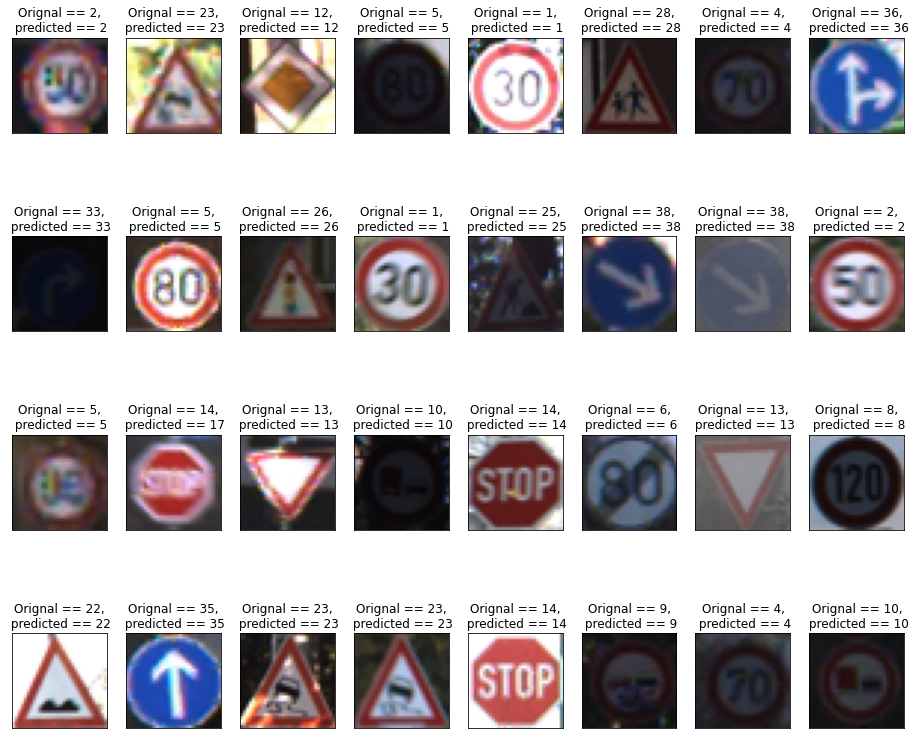

In [48]:
plt.figure(figsize=(16,14))
for i in range(32):
    plt.subplot(4,8,i+1)
    ind_ = np.random.randint(0, X_valid_orig.shape[0])
    plt.imshow((X_valid_orig)[ind_])
    y_valid_orignal = y_valid_orig[ind_]
    y_pred_s = np.argmax(y_pred_valid,axis=0)[ind_]
    plt.title('Orignal == {},\n predicted == {}'.format(y_valid_orignal, y_pred_s))
    plt.yticks([])
    plt.xticks([])


##### Visualize the instances where the model predicted inaccurately.

In [49]:
ind_incorrect = np.argwhere(y_valid_orig != np.argmax(y_pred_valid,axis=0))

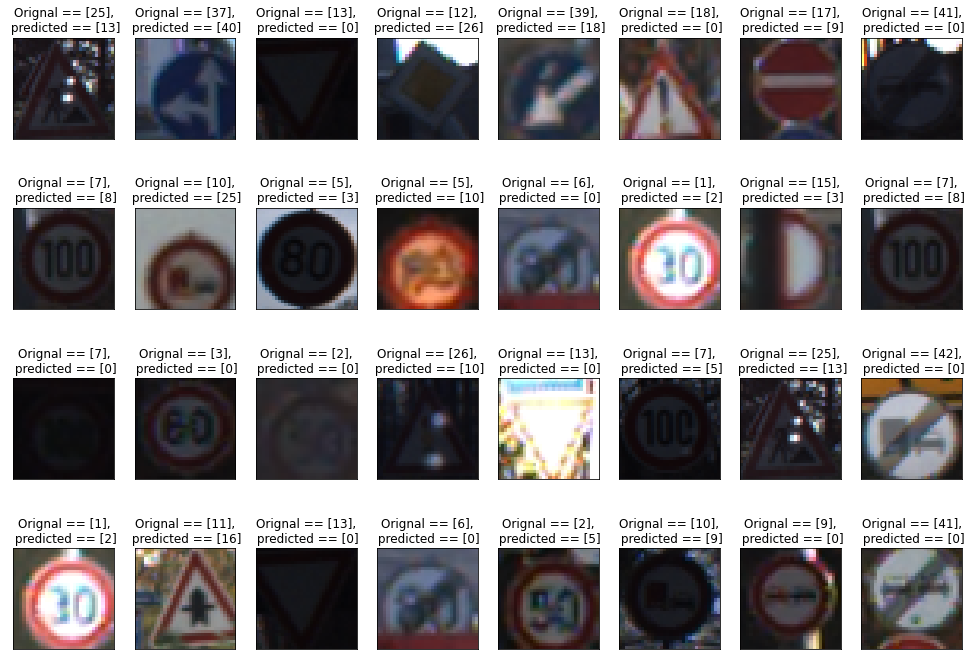

In [50]:
plt.figure(figsize=(17,12))
for i in range(32):
    plt.subplot(4,8,i+1)
    ind_ = np.random.randint(0, len(ind_incorrect))
    plt.imshow((X_valid_orig)[ind_incorrect[ind_][0]])
    y_valid_orignal = y_valid_orig[ind_incorrect[ind_]]
    y_pred_s = np.argmax(y_pred_valid,axis=0)[ind_incorrect[ind_]]
    plt.title('Orignal == {},\n predicted == {}'.format(y_valid_orignal, y_pred_s))
    plt.yticks([])
    plt.xticks([])
    # plt.tight_layout()

##### Evaluating the Neural network's performance on the test dataset.

In [51]:
X_test_p = pca.transform(X_test.T).T

In [52]:
ypred_test = predict(weightA, X_test_p)
accuracy_test = np.mean(y_test_orig==np.argmax(ypred_test,axis=0)) 
print('Accuracy achieved by Adam Optimization on Test data: {}%'.format(np.round(accuracy_test*100,2)))

Accuracy achieved by Adam Optimization on Test data: 87.11%


In [53]:
## total number of correct predictions out of 12630 images.
len(np.argwhere(y_test_orig == np.argmax(ypred_test,axis=0)))

11002